# ANN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.optim import Adam,AdamW
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from prefetch_generator import BackgroundGenerator
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib
import matplotlib.pyplot as plt 
import hiddenlayer as hl
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer,RobustScaler
from sklearn.metrics import accuracy_score
import lightgbm as lgb
#准备文件夹保存数据
local_path=os.getcwd()
if not os.path.exists(local_path+'\\blokagedata'):
    os.mkdir(local_path+'\\blokagedata')
print(local_path+'\\blokagedata')
#判断是否可以使用GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

E:\NBCode\block-DH\blokagedata


In [2]:
class DataLoaderX(DataLoader):
    def __iter__(self):
        return BackgroundGenerator(super().__iter__())
#ANN
class ANN(nn.Module):
    def __init__(self,d1,hidden_size,d2):
        super(ANN,self).__init__()
        self.ann=nn.Sequential(nn.BatchNorm1d(d1,momentum=0.5),
                               nn.Linear(d1,hidden_size),
                               nn.LeakyReLU(),
                               nn.BatchNorm1d(hidden_size,momentum=0.5),
                               nn.Linear(hidden_size,d2),
                               nn.LeakyReLU()
                              )
    def forward(self,x):
        x = self.ann(x)
        return x
#训练模型
def anntrain(args):
    model=ANN(d1=args['d1'],hidden_size=args['hidden_size'],d2=args['d2']).to(device)
    criterion=nn.CrossEntropyLoss().to(device)
    optimizer=AdamW(model.parameters(),lr=args['learning_rate'],weight_decay=args['weight_decay'])
    scheduler=LambdaLR(optimizer,verbose=False,lr_lambda=lambda epoch:1/(epoch/100+1))
    train_loader=DataLoader(dataset=train_data,batch_size=len(x_train),
                                  shuffle=True,num_workers=0)
    history1=hl.History()
    canvas1=hl.Canvas()
    best_acc=0
    for epoch in tqdm(range(args['epoches'])):
        for step,(batch_x,batch_y) in enumerate(train_loader):
            #输出层与标签之间的误差    
            model.train()
            prediction=model(batch_x)
            loss=criterion(prediction,batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #记录误差曲线和acc曲线
            steps=epoch*len(train_loader)+step+1
            if steps%25==0:
                test_acc=score_model(x_test_tensor,y_test_tensor,model)
                best_acc=test_acc if test_acc>best_acc else best_acc
                history1.log(steps,train_loss=loss.item(),test_accuracy=test_acc)
        scheduler.step()
    with canvas1:
        canvas1.draw_plot(history1['train_loss'])
        canvas1.draw_plot(history1['test_accuracy'])
    print('train_loss:%.4f'%loss.item())
    print('test_acc:%.4f'%test_acc)
    print('best_acc:%.4f'%best_acc)
    return model,best_acc
#测试数据
def run_model(data,model):
    model.eval()
    torch.no_grad()
    prediction=model(data)
    return prediction.detach()
def score_model(x_tensor,label_tensor,model):
    x=run_model(x_tensor,model)
    x=torch.argmax(x,1).unsqueeze(1)
    score=(x==label_tensor).sum().item()/len(x)
    return score

In [39]:
sample=pd.read_csv(local_path+'\\blokagedata\\sample_dp.csv',header=0)

In [57]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components='mle')
z=pca.fit_transform(x)



In [58]:
z.shape

(4578, 14)

In [62]:
sample

,Puser1,Puser2,Puser3,Puser4,Puser5,Puser6,Puser7,Puser8,Puser9,Puser10,...,DP6,DP7,DP8,DP9,DP10,index,Code,label,InnerDiameter,DN
0,-0.019792,-0.023421,0.033059,-0.024751,-0.034596,-0.024714,-0.028467,-0.033032,-0.034503,-0.027265,...,-0.269790,-0.230752,-0.391428,-0.429448,-0.233093,1,2,1,0.0225,0.05
1,0.000932,0.000435,0.004724,0.000379,0.003268,-0.000725,-0.008209,-0.024610,-0.031597,-0.004440,...,-0.001352,-0.069010,-0.311980,-0.419071,-0.036188,2,3,2,0.0225,0.05
2,-0.001392,-0.001019,-0.003961,-0.001008,-0.004312,0.000157,0.007948,0.015922,-0.010120,0.003330,...,-0.005065,0.067161,0.199544,-0.144194,0.025894,3,4,3,0.0225,0.05
3,-0.006279,-0.004869,-0.018500,-0.004882,-0.019228,0.000808,0.035175,-0.062034,-0.052221,0.013750,...,-0.021788,0.296579,-0.842271,-0.739575,0.104299,4,5,4,0.0225,0.05
4,-0.026319,-0.035822,-0.007440,-0.034896,-0.005464,-0.048183,0.014700,0.003081,-0.001688,0.025699,...,-0.635018,0.097982,-0.004489,-0.065982,0.212847,7,8,7,0.0225,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4573,-0.000150,-0.000154,-0.000144,-0.000155,-0.000154,-0.000158,-0.000164,-0.000159,-0.000157,-0.000163,...,0.003621,-0.004577,-0.005037,-0.004768,-0.008316,6183,64,63,0.4275,0.95
4574,0.000042,0.000043,0.000040,0.000043,0.000043,0.000044,0.000046,0.000045,0.000044,0.000046,...,-0.000593,-0.000698,-0.001022,-0.001072,-0.000741,6184,65,64,0.4275,0.95
4575,-0.000028,-0.000029,-0.000027,-0.000029,-0.000029,-0.000030,-0.000031,-0.000030,-0.000030,-0.000031,...,-0.001151,0.000722,0.001296,0.001433,0.000621,6185,66,65,0.4275,0.95
4576,-0.000349,-0.000357,-0.000334,-0.000359,-0.000357,-0.000366,-0.000381,-0.000370,-0.000365,-0.000378,...,-0.000962,0.005734,0.000421,-0.002088,0.008210,6186,67,66,0.4275,0.95


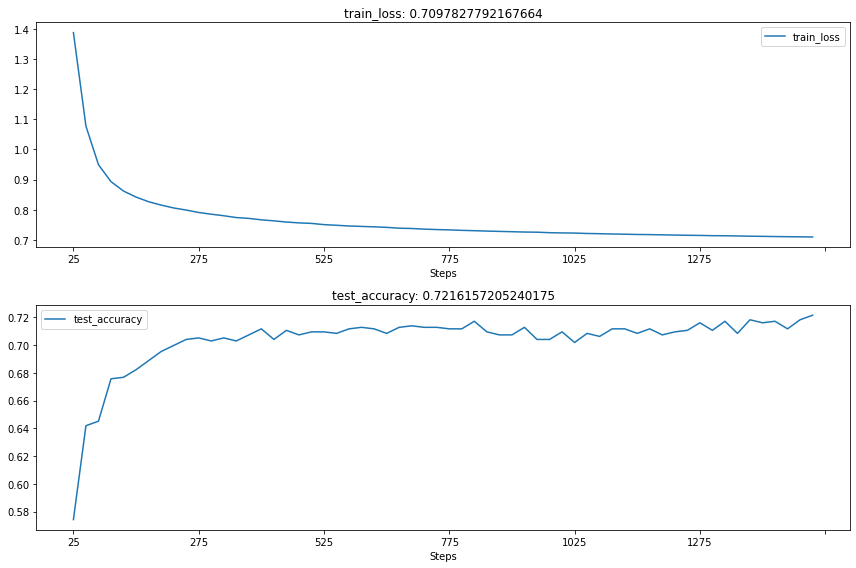

  0%|          | 0/1500 [00:00<?, ?it/s]

train_loss:0.7098
test_acc:0.7216
best_acc:0.7216
train_acc: 0.7408519934462042
acc: [0.7216157205240175]


 10%|█         | 153/1500 [00:07<01:04, 21.00it/s]


KeyboardInterrupt: 

In [61]:
#读取模型数据
sample=pd.read_csv(local_path+'\\blokagedata\\sample_percent.csv',header=0)
#划分样本和标签
x=np.array(sample.iloc[:,range(0,15)])#.astype(int)
y=np.array(sample.loc[:,'label']).reshape(-1,1).astype(int)
#训练模型

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
score_record=[]
hs_record=[]
for hs in range(50,300,10):
    params={
    "d1":15,
    "hidden_size": hs,
    "d2":68,
    "learning_rate":0.01,
    "epoches":1500,
    "weight_decay":0.01
    }
    acc=[]
    for train_index, test_index in skf.split(x,y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        #qt
#         pca = PCA(n_components=14)
#         x_train=pca.fit_transform(x_train)
#         x_test=pca.transform(x_test)
        
        qt = QuantileTransformer(output_distribution = 'uniform' )
        x_train = qt.fit_transform(x_train)
        x_test = qt.transform(x_test)
        
        
        #numpy转为张量
        x_train_tensor=torch.from_numpy(x_train).float().to(device)
        y_train_tensor=torch.from_numpy(y_train).to(device)
        x_test_tensor=torch.from_numpy(x_test).float().to(device)
        y_test_tensor=torch.from_numpy(y_test).to(device)
        train_data=Data.TensorDataset(x_train_tensor,y_train_tensor.long().squeeze())
        annmodel,best_acc=anntrain(params)
        train_acc=score_model(x_train_tensor,y_train_tensor,annmodel)
        print('train_acc:',train_acc)
        acc.append(best_acc)
        print('acc:',acc)
    ave_score=np.mean(acc)
    print('ave_acc',ave_score)
    score_record.append(ave_score)
    hs_record.append(hs)
    print('score_record:',score_record)
    print('hs_record:',hs_record)

# SVM

In [21]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV,StratifiedKFold,cross_validate
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer,MinMaxScaler
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.pipeline import Pipeline
from scipy.stats import loguniform,uniform,randint
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
#准备文件夹保存数据
local_path=os.getcwd()
if not os.path.exists(local_path+'\\blokagedata'):
    os.mkdir(local_path+'\\blokagedata')
print(local_path+'\\blokagedata')

E:\NBCode\block-DH\blokagedata


In [28]:
pipe = Pipeline([('scaler', QuantileTransformer(output_distribution = 'uniform')), ('svc', SVC(decision_function_shape='ovr',kernel='rbf'))])
param_dist = {'svc__C': [1000,10000,100000,500000,800000,1000000],
 'svc__gamma': [0.1,0.5,1,1.5,2,5]}
splitter=StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
clf = GridSearchCV(estimator=pipe,param_grid=param_dist,cv=splitter,n_jobs=-1,scoring='accuracy',verbose=3)
search = clf.fit(x, y.ravel())

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [14]:
print('网格搜索-度量记录：',search.cv_results_)  # 包含每次训练的相关信息
print('网格搜索-最佳度量值:',search.best_score_)  # 获取最佳度量值
print('网格搜索-最佳参数：',search.best_params_)  # 获取最佳度量值时的代定参数的值。是一个字典
print('网格搜索-最佳模型：',search.best_estimator_)  # 获取最佳度量时的分类器模型

网格搜索-度量记录： {'mean_fit_time': array([1.82281404, 1.66114206, 1.4761086 , 1.39565058, 1.41523018,
       1.39826593, 1.31263762, 1.30555615, 1.10935378, 2.31594267,
       1.14402719, 0.9457046 , 0.88836079, 0.77618899, 0.81109128,
       0.71761994, 0.67617688, 0.72523932, 0.70464301, 1.19239979,
       0.65086927, 0.65123701, 0.60282125, 0.59041648, 0.59724317,
       0.58560572, 0.58100786, 0.57000265, 0.60633039, 0.65250998,
       0.60962009, 0.73477373, 0.61916127, 0.59590573, 0.64544501,
       0.66057925, 0.62130494, 0.65279226, 0.66574264, 0.56234441,
       0.67787952, 0.71043811, 0.75340915, 0.77122965, 0.77800069,
       0.8985672 , 0.92968659, 0.92174859, 0.86226678, 0.62610464,
       0.92734127, 1.09333425, 1.26475639, 1.47116113, 1.6001718 ,
       1.7181458 , 1.96472535, 2.02159929, 2.24392824, 0.88414931,
       1.54728184, 2.25267024, 2.83688169, 3.41358895, 4.15143418,
       4.65048575, 5.26949062, 5.60429296, 6.38756509, 1.46944957,
       1.71905398, 2.7355958 , 3.

In [29]:
xx=search.cv_results_['param_svc__C'].data.astype(float)
yy=search.cv_results_['param_svc__gamma'].data.astype(float)
zz=search.cv_results_['mean_test_score'].astype(float)
xx=np.expand_dims(xx,axis=1)
yy=np.expand_dims(yy,axis=1)
zz=np.expand_dims(zz,axis=1)
print(xx.shape)
print(yy.shape)
print(zz.shape)
zxc=pd.DataFrame(np.hstack((xx,yy,zz)))
zxc.columns=['C','gamma','acc']
zxc=pd.pivot_table(zxc,index=['C'],columns=['gamma'],values=['acc'])
# zxc.to_csv(local_path+'\\blokagedata\\svm_finetune_grid_b.csv',encoding='ascii',index=True)

(36, 1)
(36, 1)
(36, 1)


In [30]:
zxc

acc                                                  
gamma           0.1       0.5       1.0       1.5       2.0       5.0
C                                                                    
1000.0     0.718658  0.733947  0.740282  0.738752  0.738753  0.741374
10000.0    0.735475  0.739625  0.738752  0.740281  0.740280  0.740062
100000.0   0.738533  0.739406  0.737659  0.737222  0.736567  0.730669
500000.0   0.738314  0.736785  0.734601  0.733946  0.729795  0.716253
800000.0   0.738532  0.737222  0.731761  0.730669  0.728921  0.709481
1000000.0  0.737877  0.736130  0.731762  0.729140  0.727175  0.705548

# RF

In [33]:
pipe = Pipeline([('scaler', QuantileTransformer(output_distribution = 'uniform')), ('rfc', RandomForestClassifier(criterion='gini'))])
param_dist = {'rfc__n_estimators': [200]}
splitter=StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
clf = RandomizedSearchCV(estimator=pipe,param_distributions=param_dist,n_iter=10,cv=splitter,random_state=11,n_jobs=-1,scoring='accuracy',verbose=3)
search = clf.fit(x, y.ravel())

E:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [34]:
print('网格搜索-度量记录：',search.cv_results_)  # 包含每次训练的相关信息
print('网格搜索-最佳度量值:',search.best_score_)  # 获取最佳度量值
print('网格搜索-最佳参数：',search.best_params_)  # 获取最佳度量值时的代定参数的值。是一个字典
print('网格搜索-最佳模型：',search.best_estimator_)  # 获取最佳度量时的分类器模型

网格搜索-度量记录： {'mean_fit_time': array([3.52501693]), 'std_fit_time': array([0.01285532]), 'mean_score_time': array([0.12523541]), 'std_score_time': array([0.00773251]), 'param_rfc__n_estimators': masked_array(data=[200],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'rfc__n_estimators': 200}], 'split0_test_score': array([0.6058952]), 'split1_test_score': array([0.60152838]), 'split2_test_score': array([0.60917031]), 'split3_test_score': array([0.61202186]), 'split4_test_score': array([0.62622951]), 'mean_test_score': array([0.61096905]), 'std_test_score': array([0.00839161]), 'rank_test_score': array([1])}
网格搜索-最佳度量值: 0.6109690505166203
网格搜索-最佳参数： {'rfc__n_estimators': 200}
网格搜索-最佳模型： Pipeline(steps=[('scaler', QuantileTransformer()),
                ('rfc', RandomForestClassifier(n_estimators=200))])


# kNN

In [48]:
pipe = Pipeline([('scaler', QuantileTransformer(output_distribution = 'uniform')), ('knn', KNeighborsClassifier())])
param_dist = {'knn__n_neighbors': [15,16,17,18,19,20,21,22]}
splitter=StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
clf = RandomizedSearchCV(estimator=pipe,param_distributions=param_dist,n_iter=9,cv=splitter,random_state=1,n_jobs=-1,scoring='accuracy',verbose=3)
search = clf.fit(x, y.ravel())

E:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=9. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [45]:
print('网格搜索-度量记录：',search.cv_results_)  # 包含每次训练的相关信息
print('网格搜索-最佳度量值:',search.best_score_)  # 获取最佳度量值
print('网格搜索-最佳参数：',search.best_params_)  # 获取最佳度量值时的代定参数的值。是一个字典
print('网格搜索-最佳模型：',search.best_estimator_)  # 获取最佳度量时的分类器模型

网格搜索-度量记录： {'mean_fit_time': array([0.30746832, 0.30986977, 0.30727196, 0.30027404, 0.29197254,
       0.29366813, 0.23965325, 0.1852397 ]), 'std_fit_time': array([0.01617189, 0.01763997, 0.01116274, 0.01429041, 0.00381332,
       0.00531534, 0.04529707, 0.0229683 ]), 'mean_score_time': array([0.06481915, 0.06381974, 0.06652055, 0.06191788, 0.07561622,
       0.07761507, 0.05641303, 0.04501586]), 'std_score_time': array([0.00585839, 0.00262122, 0.00266679, 0.00358279, 0.00993302,
       0.00527749, 0.01507015, 0.00632024]), 'param_knn__n_neighbors': masked_array(data=[2, 5, 8, 13, 16, 19, 24, 27],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'knn__n_neighbors': 2}, {'knn__n_neighbors': 5}, {'knn__n_neighbors': 8}, {'knn__n_neighbors': 13}, {'knn__n_neighbors': 16}, {'knn__n_neighbors': 19}, {'knn__n_neighbors': 24}, {'knn__n_neighbors': 27}], 'split0_test_score': array([0.63100437, 0.66921397, 

In [49]:
xx=search.cv_results_['param_knn__n_neighbors'].data.astype(float)
zz=search.cv_results_['mean_test_score'].astype(float)
xx=np.expand_dims(xx,axis=1)
zz=np.expand_dims(zz,axis=1)
print(xx.shape)
print(zz.shape)
zxc=pd.DataFrame(np.hstack((xx,zz)))
zxc.columns=['k','acc']
# zxc.to_csv(local_path+'\\blokagedata\\knn_finetune.csv',encoding='ascii',index=True)

(8, 1)
(8, 1)


In [50]:
zxc

,k,acc
0,15.0,0.699650
1,16.0,0.698341
2,17.0,0.698998
3,18.0,0.701399
4,19.0,0.701399
5,20.0,0.702055
6,21.0,0.698340
7,22.0,0.695500
